Straight-forward mapping the verilog benchmarks to the required format

In [1]:
import re
import os

In [2]:
def find_neighbors(all_idx, signal, wire_id = 0):
    frontier = [signal]
    neighbors = []
    while len(frontier) > 0:
        current = frontier.pop(0)
        
        for (e1,r,e2) in all_idx:
            if e1 == current[2]:
                if r == wire_id:
                    frontier.append((e1,r,e2))
                else:
                    neighbors.append([e1,r,e2])
            if e2 == current[0]:
                if r == wire_id:
                    frontier.append((e1,r,e2))
                else:
                    neighbors.append([e1,r,e2])
    return neighbors
    

In [5]:
def extract_input_output_pairs_trojan(filename):
    original_v = ''
    with open(filename, 'rt') as f:
        original_v = f.read()
    
    signal_lists = []
    
    trojan_signals = []
    safe_signals = []
    triggering_events_signals = []
    
    first_order_triggering_events = []
    
    trojan_gate_name = r'.*troj.*'
    
    output_strings = []
    
    entities_set = set()
    relations_set = set()
    
    safe_ids = []
    trojan_ids = []
    
    matches = re.findall(r'\n\s*([A-Za-z0-9_]+)\s+([A-Za-z0-9_]+)\s*\((.*)\).*;', original_v)
    for m in matches:
        #print(m[1])
        gate_type = m[0]
        gate_name = m[1]
        signal_list = re.split(r'[\s\(\),]+', m[2])
        signal_list = list(filter(lambda x: len(x) > 0, signal_list))
        input_list = signal_list[::2]
        signal_list = signal_list[1::2]
        
        relations = list([gate_type + x for x in input_list])
        
        #print(signal_list)
        gate_output = signal_list[0]
        signal_list = signal_list[1:]
        
        tab = '\t'
        
        for signal, relation in zip(signal_list, relations):
            output_string = f"{gate_name}{tab}{relation}{tab}{signal}\n"
            output_strings.append(output_string)
            
            entities_set.add(gate_name)
            entities_set.add(signal)
            relations_set.add(relation)
            
            #if bool(signal.find('troj') != -1) != bool(gate_name.find('troj') != -1):
            #    first_order_triggering_events.append((gate_name, relation, signal))
            
            if re.match(trojan_gate_name, gate_name):
                trojan_signals.append((gate_name, relation, signal))
                #triggering_events_signals.append()
            else:
                #if signal.find('troj') != -1:
                #if re.match(trojan_gate_name, signal):
                 #   print('Event!')
                 #   first_order_triggering_events.append((gate_name, relation, signal))
                safe_signals.append((gate_name, relation, signal))
                
        
        if bool(gate_output.find('troj') != -1) != bool(gate_name.find('troj') != -1):
                first_order_triggering_events.append((gate_name, relation, signal))
        
        output_strings.append(f"{gate_output}{tab}wire{tab}{gate_name}\n")
        if re.match(trojan_gate_name, gate_name):
            trojan_signals.append((gate_output, 'wire', gate_name))
        else:
            safe_signals.append((gate_output, 'wire', gate_name))
        entities_set.add(gate_name)
        entities_set.add(gate_output)
        relations_set.add('wire')
        
    entities_to_id = {x: i for (i, x) in enumerate(sorted(entities_set))}
    relations_to_id = {x: i for (i, x) in enumerate(sorted(relations_set))}
    
    wire_id = relations_to_id['wire']
    
    trojan_signals_idx = [[entities_to_id[e1], relations_to_id[r], entities_to_id[e2]] for (e1, r, e2) in trojan_signals]
    safe_signals_idx = [[entities_to_id[e1], relations_to_id[r], entities_to_id[e2]] for (e1, r, e2) in safe_signals]
    first_order_idx = [[entities_to_id[e1], relations_to_id[r], entities_to_id[e2]] for (e1, r, e2) in first_order_triggering_events]
    
   
    
    def test(safe):
        #if safe[0]
        print(safe)
        return False
        #return safe[0] == e1
    
    # list(filter(lambda (safe_e1, safe_r, safe_e2): safe_e1 == e2 , safe-signals_idx))  
    #triggering_events_idx = [ list( filter((lambda safe: safe[0] == e2), safe_signals_idx) ) for (e1,r,e2) in trojan_signals_idx]
    join = [(trojan[2], safe[0], safe[1], safe[2]) for safe in safe_signals_idx for trojan in trojan_signals_idx if safe[2] == trojan[0]]
    #triggering_events_idx = [ list( filter(test, safe_signals_idx) ) for (e1,r,e2) in trojan_signals_idx]
    
    #print(trojan_signals_idx)
    #print('triggering events')
    #print(first_order_idx)
    #print(join)
    
#     for i in safe_signals_idx:
#         if i[0] == 185:
#             print(i)
    

    
    
    all_idx = safe_signals_idx + trojan_signals_idx
    
    neighbors = []
    for i in first_order_idx:
        neighbors.append(find_neighbors(all_idx, i, wire_id))
    
    neighbors_ids = []
    for n in neighbors:
        neighbors_ids.append( [i for i in range(len(all_idx)) if all_idx[i] in n] )
    
    print('neighbors:', neighbors)
    print('neighbors ids:', neighbors_ids)
    
    first_order_ids = [i for i in range(len(all_idx)) if all_idx[i] in first_order_idx]
    
    
    
    with open('./all_idx.txt', 'w') as f:
        for item in all_idx:
            f.write("%s\n" % item)
    
    #print(len(safe_signals_idx), len(trojan_signals_idx))
        
    return output_strings, all_idx, safe_signals_idx, trojan_signals_idx, first_order_ids, neighbors_ids

In [6]:
def train_netlist_embeddings(filename, num_epochs = 30):
    strings, all_idx, safe_idx, trojan_idx, first_order_ids, neighbors_ids = extract_input_output_pairs_trojan(filename)
    from kbc import process_datasets
    
    from kbc.datasets import Dataset
    from kbc.models import CP, ComplEx
    from kbc.regularizers import F2, N3
    from kbc.optimizers import KBCOptimizer
    from kbc.process_datasets import prepare_dataset
    
    from pathlib import Path
    import pkg_resources
    
    import shutil


    
    import torch
    from torch import optim

    import tqdm
    
    if not os.path.exists('./tmp'):
        os.makedirs('./tmp')
    
    with open('./tmp/train', 'wt') as f:
            f.writelines(strings)
    with open('./tmp/valid', 'wt') as f:
            f.writelines(strings)
    with open('./tmp/test', 'wt') as f:
            f.writelines(strings)
    
    
    DATA_PATH = pkg_resources.resource_filename('kbc', 'data/')
    if os.path.exists(Path(DATA_PATH) / filename):
        shutil.rmtree(Path(DATA_PATH) / filename)
        
    
    prepare_dataset('./tmp/', filename)
    
    
    dataset = Dataset(filename)
   
    model = ComplEx(dataset.get_shape(), 200)
    
    device = 'cuda'
    model.to(device)
    
    regularizer = N3(0.00001)
    examples = torch.from_numpy(dataset.get_train().astype('int64'))
    
    optimizer = KBCOptimizer(model, regularizer, optim.Adagrad(model.parameters(), lr=0.1), batch_size=256, verbose = False)

    
    
    cur_loss = 0
    curve = {'train': [], 'valid': [], 'test': []}

    for e in tqdm.tqdm (range(num_epochs)):
        cur_loss = optimizer.epoch(examples)
    
    print(len(all_idx))
    embeddings = model.get_queries(torch.tensor(all_idx).to("cuda"))
    embeddings = embeddings.cpu().detach().numpy()
    return embeddings, first_order_ids, neighbors_ids


In [7]:
def draw_embeddings(embeddings, mask = []):
    import numpy as np
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1000)
    lowdim = tsne.fit_transform(embeddings)
    
    masked = lowdim[mask]
    print(masked)
    
    plt.scatter(lowdim.transpose()[0], lowdim.transpose()[1])
    plt.scatter(masked.transpose()[0], masked.transpose()[1], color = 'orange')
    plt.show()

neighbors: [[[673, 8, 1484], [1530, 4, 1462], [1530, 5, 1448], [1530, 6, 1416], [1530, 7, 1537]], [[470, 8, 1413], [1531, 4, 1049], [1531, 5, 931], [1531, 6, 1538], [1531, 7, 1536]], [[705, 2, 973], [1532, 1, 1538]], [[1529, 10, 1536], [1529, 11, 1537], [1529, 12, 205], [1533, 17, 1535], [371, 9, 1094], [1533, 13, 985], [1533, 14, 1103], [1533, 15, 1102], [1533, 16, 1539], [1533, 17, 1535]], [[807, 0, 1499], [1534, 13, 1337], [1534, 14, 1311], [1534, 15, 1171], [1534, 16, 1139], [1534, 17, 1539]], [[1540, 19, 205], [1540, 20, 1293]]]
neighbors ids: [[1488, 1940, 1941, 1942, 1943], [956, 1945, 1946, 1947, 1948], [144, 1950], [702, 1936, 1937, 1938, 1952, 1953, 1954, 1955, 1956], [1842, 1958, 1959, 1960, 1961, 1962], [1964, 1965]]
1541 entities and 21 relations
creating filtering lists


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


1967
[[1488, 1940, 1941, 1942, 1943], [956, 1945, 1946, 1947, 1948], [144, 1950], [702, 1936, 1937, 1938, 1952, 1953, 1954, 1955, 1956], [1842, 1958, 1959, 1960, 1961, 1962], [1964, 1965]]
HT embeddings, connected to safe hardware:
[[-0.22561166  0.18705377]
 [-0.22911201  0.21879774]
 [-0.1932014   0.2067051 ]
 [-0.18783398  0.24135697]
 [-0.21148619  0.23252334]
 [-0.11240536  0.21194752]]


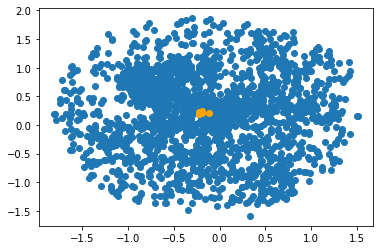

[[ 1.358207    0.72337824]
 [-0.04738472 -0.0766277 ]
 [ 0.00321548 -0.08758985]
 [ 0.02308653 -0.09897804]
 [-0.09531742 -0.14725883]]


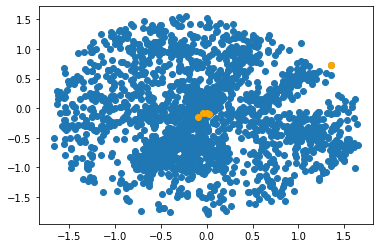

[[-1.0573267  -1.1660807 ]
 [-0.25377944 -0.00310873]
 [-0.17274573  0.06048058]
 [-0.17243333  0.10604236]
 [-0.22601023  0.11957455]]


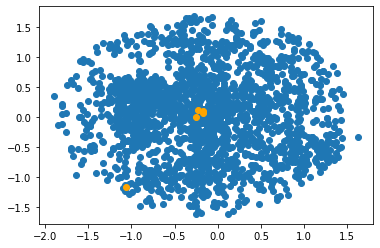

[[ 1.3872943   0.71357036]
 [-0.10072659 -0.0775065 ]]


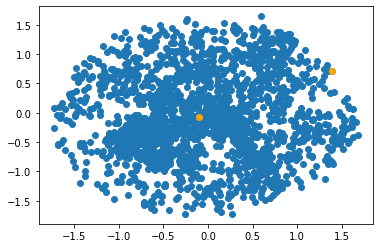

[[-0.935918   -1.0762714 ]
 [ 0.23865302 -0.02914477]
 [ 0.22088183 -0.04682196]
 [ 0.21311735 -0.03610558]
 [ 0.2237629  -0.02332813]
 [ 0.131873    0.06351175]
 [ 0.1642837   0.04379013]
 [ 0.23938508 -0.0425268 ]
 [ 0.25790244  0.00958681]]


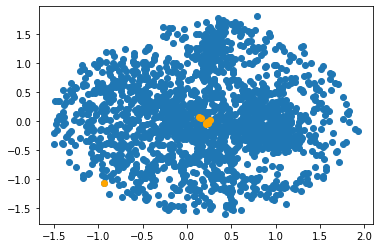

[[-0.24181287  0.06591753]
 [ 0.2891376   0.08566001]
 [ 0.20234857  0.06693985]
 [ 0.14958356 -0.09656388]
 [ 0.2609998  -0.02313609]
 [ 0.28869843  0.03586893]]


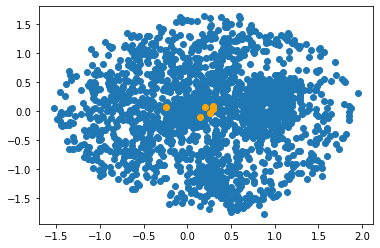

[[0.07826825 0.13155213]
 [0.11211821 0.04848609]]


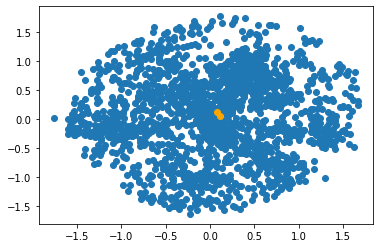

In [258]:
embeddings, first_order_ids, neighbors_ids = train_netlist_embeddings('benches/c2670_T001.v')
print(neighbors_ids)
print('HT embeddings, connected to safe hardware:')
draw_embeddings(embeddings, first_order_ids)

for n in neighbors_ids:
    draw_embeddings(embeddings, n)

#strings = extract_input_output_pairs_trojan('benches/c2670_T001.v')

In [ ]:
def extract_input_output_pairs(filename):
    original_v = ''
    with open(filename, 'rt') as f:
        original_v = f.read()
    
    signal_lists = []
    
    trojan_signals = []
    safe_sugnals = []
    
    output_strings = []
    
    matches = re.findall(r'\n\s*([A-Za-z0-9_]+)\s+([A-Za-z0-9_]+)\s*\((.*)\).*;', original_v)
    for m in matches:
        #print(m[1])
        gate_type = m[0]
        gate_name = m[1]
        signal_list = re.split(r'[\s\(\),]+', m[2])
        signal_list = list(filter(lambda x: len(x) > 0, signal_list))
        input_list = signal_list[::2]
        signal_list = signal_list[1::2]
        
        relations = list([gate_type + x for x in input_list])
        
        #print(signal_list)
        gate_output = signal_list[0]
        signal_list = signal_list[1:]
        
        tab = '\t'
        
        for signal, relation in zip(signal_list, relations):
            output_string = f"{gate_name}{tab}{relation}{tab}{signal}\n"
            output_strings.append(output_string)
            
        output_strings.append(f"{gate_output}{tab}wire{tab}{gate_name}\n")
        
    return output_strings

In [3]:
strings = extract_input_output_pairs('benches/c2670_T001.v')
with open('./graph/train', 'wt') as f:
        f.writelines(strings)
with open('./graph/valid', 'wt') as f:
        f.writelines(strings)
with open('./graph/test', 'wt') as f:
        f.writelines(strings)

Running KBC model

In [4]:

from kbc import process_datasets

In [27]:
path = './graph/c2670_T002'
files = ['train', 'valid', 'test']
entities, relations = set(), set()
for f in files:
    file_path = os.path.join(path, f)
    to_read = open(file_path, 'r')
    for line in to_read.readlines():
        lhs, rel, rhs = line.strip().split('\t')
        entities.add(lhs)
        entities.add(rhs)
        relations.add(rel)
    to_read.close()

entities_to_id = {x: i for (i, x) in enumerate(sorted(entities))}
relations_to_id = {x: i for (i, x) in enumerate(sorted(relations))}
print("{} entities and {} relations".format(len(entities), len(relations)))
n_relations = len(relations)
n_entities = len(entities)
#process_datasets.prepare_dataset('./graph','test_graph_2')

1541 entities and 21 relations


In [4]:
from kbc.datasets import Dataset
from kbc.models import CP, ComplEx
from kbc.regularizers import F2, N3
from kbc.optimizers import KBCOptimizer

import torch
from torch import optim

import tqdm

dataset = Dataset('curcuit_c2670_T002')
examples = torch.from_numpy(dataset.get_train().astype('int64'))
model = ComplEx(dataset.get_shape(), 200)
regularizer = N3(0.00001)

device = 'cuda'
model.to(device)

optimizer = KBCOptimizer(model, regularizer, optim.Adagrad(model.parameters(), lr=0.1), batch_size=256)

cur_loss = 0
curve = {'train': [], 'valid': [], 'test': []}

max_epochs = 30 

for e in tqdm.tqdm (range(max_epochs)):
    cur_loss = optimizer.epoch(examples)


    

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.63it/s]


In [7]:
print(model.embeddings[0].weight.shape)
model.get_queries(torch.tensor([[1540,1],[1540,20],[1,3,],[3,2]]).to("cuda"))

torch.Size([1541, 400])


tensor([[-0.0319, -0.1397, -0.0516,  ..., -0.1331, -0.0933,  0.0309],
        [-0.0997,  0.0526, -0.0178,  ...,  0.1698, -0.0690,  0.0911],
        [ 0.0939, -0.0007, -0.0343,  ..., -0.5400, -0.2763, -0.4578],
        [ 0.1018, -0.1448, -0.4423,  ...,  0.0954,  0.1747, -0.0746]],
       device='cuda:0', grad_fn=<CatBackward>)

In [9]:
trojan_orig ="""troj1_0U1	nor3s1.DIN1	troj1_0n2
troj1_0U1	nor3s1.DIN2	troj1_0n3
troj1_0U1	nor3s1.DIN3	Trigger_en1_0
troj1_0n1	wire	troj1_0U1
troj1_0U2	nnd4s1.DIN1	n850
troj1_0U2	nnd4s1.DIN2	n836
troj1_0U2	nnd4s1.DIN3	n804
troj1_0U2	nnd4s1.DIN4	troj1_0n3
n872	wire	troj1_0U2
troj1_0U3	nnd4s1.DIN1	n437
troj1_0U3	nnd4s1.DIN2	n319
troj1_0U3	nnd4s1.DIN3	troj1_0n4
troj1_0U3	nnd4s1.DIN4	troj1_0n2
n801	wire	troj1_0U3
troj1_0U4	i1s1.DIN	troj1_0n4
n361	wire	troj1_0U4
troj1_0U5	or5s1.DIN1	n373
troj1_0U5	or5s1.DIN2	n491
troj1_0U5	or5s1.DIN3	n490
troj1_0U5	or5s1.DIN4	troj1_0n5
troj1_0U5	or5s1.DIN5	troj1_0n1
n482	wire	troj1_0U5
troj1_0U6	or5s1.DIN1	n725
troj1_0U6	or5s1.DIN2	n699
troj1_0U6	or5s1.DIN3	n559
troj1_0U6	or5s1.DIN4	n527
troj1_0U6	or5s1.DIN5	troj1_0n5
n887	wire	troj1_0U6
trojan1_0	xor2s1.DIN1	Trigger_en1_0
trojan1_0	xor2s1.DIN2	n681
tempn681	wire	trojan1_0
"""

trojan ="""troj2_0U1	and4s1.DIN1	troj2_0n1
troj2_0U1	and4s1.DIN2	troj2_0n2
troj2_0U1	and4s1.DIN3	troj2_0n3
troj2_0U1	and4s1.DIN4	Trigger_en2_0
troj2_0U2	nor5s1.DIN1	n486
troj2_0U2	nor5s1.DIN2	n556
troj2_0U2	nor5s1.DIN3	n592
troj2_0U2	nor5s1.DIN4	n560
troj2_0U2	nor5s1.DIN5	troj2_0n3
troj2_0U3	nor2s1.DIN1	n386
troj2_0U3	nor2s1.DIN2	troj2_0n2
troj2_0U4	i1s1.DIN	troj2_0n1
trojan2_0	xor2s1.DIN1	Trigger_en2_0
trojan2_0	xor2s1.DIN2	n387"""


trojan_idx = []

for line in trojan.splitlines():
        lhs, rel, rhs = line.strip().split('\t')
        idx = [entities_to_id[lhs], relations_to_id[rel], entities_to_id[rhs]]
        trojan_idx.append(idx)
        print( idx )

all_idx = []
to_read = open(f"./graph/c2670_T002/train", 'r')
counter = 0
for line in to_read.readlines():
    lhs, rel, rhs = line.strip().split('\t')
    idx = [entities_to_id[lhs], relations_to_id[rel], entities_to_id[rhs]]

    #if rhs in input_nets:
    #    input_gates_idx.append(counter)

    all_idx.append(idx)
    counter += 1
to_read.close()

#print(len(all_idx))
for idx in trojan_idx:
    if idx in all_idx:
        all_idx.remove(idx)

print(len(all_idx))

[1529, 0, 1533]
[1529, 1, 1534]
[1529, 2, 1535]
[1529, 3, 205]
[1530, 11, 1098]
[1530, 12, 1168]
[1530, 13, 1204]
[1530, 14, 1172]
[1530, 15, 1535]
[1531, 8, 998]
[1531, 9, 1534]
[1532, 5, 1533]
[1536, 17, 205]
[1536, 18, 999]
1941


In [10]:
embeddings_high_dim = model.get_queries(torch.tensor(all_idx).to("cuda"))
trojan_embeddings_high_dim = model.get_queries(torch.tensor(trojan_idx).to("cuda"))


In [11]:
print(embeddings_high_dim.shape)

torch.Size([1941, 400])


In [12]:
np_embeddings_high_dim = embeddings_high_dim.cpu().detach().numpy()
np_trojan_embeddings_high_dim = trojan_embeddings_high_dim.cpu().detach().numpy()

print (np_trojan_embeddings_high_dim.shape)

(14, 400)


(1941, 2)


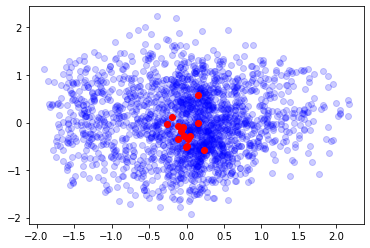

[-9.15881898e-03 -2.35186215e-03 -3.08166891e-02 -4.55780048e-03
  6.10677712e-03  1.25948563e-02  2.19813664e-03 -7.02646235e-03
 -6.48558186e-03 -1.00335488e-02 -2.46964935e-02 -1.20828627e-04
 -5.06174751e-03 -1.53477006e-02 -4.84639459e-04  1.13882986e-03
 -5.75279212e-03  1.42805632e-02  3.07412893e-02  5.42238308e-03
  5.38459513e-03 -3.07304692e-03 -4.36189817e-03  1.46376090e-02
  8.44275113e-03 -3.58625595e-03 -2.39868760e-02  9.56971315e-04
  4.37528873e-03 -4.87736007e-03 -1.27329845e-02  2.47858069e-03
  6.66490756e-03 -5.06599322e-02  8.28750804e-03  1.55446427e-02
 -7.70792179e-03 -1.54803582e-02 -4.84460359e-03  6.26962772e-03
  1.63584240e-02  6.99166069e-03 -2.68507469e-02 -5.96895516e-02
  1.60842184e-02 -1.20776715e-02 -1.67099051e-02  3.13500222e-03
 -1.33556584e-02 -4.05006995e-03  1.82184577e-03 -9.08393133e-03
  1.04159612e-04  5.34295756e-03  1.00097274e-02 -5.04582014e-04
  5.49268490e-03 -1.73944812e-02 -1.66141149e-02  2.28690542e-03
 -3.02588828e-02  1.16845

In [13]:
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim)))

trojans_lowdim = pca.transform(np_trojan_embeddings_high_dim)
non_trojans_lowdim = pca.transform(np_embeddings_high_dim)

print(non_trojans_lowdim.shape)

plt.scatter(non_trojans_lowdim.transpose()[0], non_trojans_lowdim.transpose()[1], alpha = 0.2, c ="blue")
plt.scatter(trojans_lowdim.transpose()[0], trojans_lowdim.transpose()[1], alpha = 1.0, c ="red")

plt.show()

print(np.mean(np_embeddings_high_dim, axis = 0) )
print(np.mean(np_trojan_embeddings_high_dim, axis = 0) )

print(np.sort(np.std(np_embeddings_high_dim, axis = 0)) )
print(np.sort(np.std(np_trojan_embeddings_high_dim, axis = 0)) )

Low perplexity


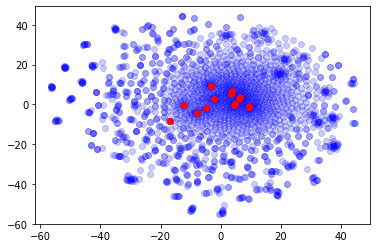

High perplexity


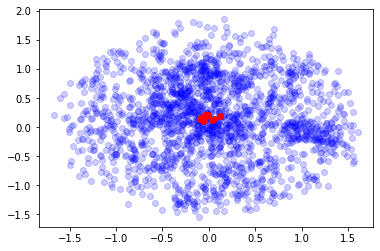

In [14]:
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
#tsne.fit(np.asarray(np_embeddings_high_dim, dtype='float64'))
lowdim = tsne.fit_transform(np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim)))

#trojans_lowdim = tsne.transform(np_trojan_embeddings_high_dim)
#non_trojans_lowdim = tsne.transform(np_embeddings_high_dim)

#print(non_trojans_lowdim.shape)

print('Low perplexity')
plt.scatter(lowdim.transpose()[0, :np_embeddings_high_dim.shape[0]], lowdim.transpose()[1, :np_embeddings_high_dim.shape[0]], alpha = 0.2, c ="blue")
plt.scatter(lowdim.transpose()[0, np_embeddings_high_dim.shape[0]:], lowdim.transpose()[1, np_embeddings_high_dim.shape[0]:], alpha = 1.0, c ="red")

plt.show()


tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1000)
#tsne.fit(np.asarray(np_embeddings_high_dim, dtype='float64'))
lowdim = tsne.fit_transform(np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim)))

#trojans_lowdim = tsne.transform(np_trojan_embeddings_high_dim)
#non_trojans_lowdim = tsne.transform(np_embeddings_high_dim)

#print(non_trojans_lowdim.shape)

print('High perplexity')
plt.scatter(lowdim.transpose()[0, :np_embeddings_high_dim.shape[0]], lowdim.transpose()[1, :np_embeddings_high_dim.shape[0]], alpha = 0.2, c ="blue")
plt.scatter(lowdim.transpose()[0, np_embeddings_high_dim.shape[0]:], lowdim.transpose()[1, np_embeddings_high_dim.shape[0]:], alpha = 1.0, c ="red")

plt.show()

In [16]:
true_labels = np.concatenate((np.zeros(np_embeddings_high_dim.shape[0]), np.ones(np_trojan_embeddings_high_dim.shape[0])))
print(true_labels.shape)
embeddings = np.concatenate((np_embeddings_high_dim, np_trojan_embeddings_high_dim))
print(embeddings.shape)

(1955,)
(1955, 400)


In [17]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

epsilon = 5.0
min_samples = 2
cluster_method = 'xi'
metric = 'minkowski'

clust = OPTICS(max_eps=epsilon, min_samples=min_samples, cluster_method=cluster_method, metric=metric)
clust.fit(embeddings)

E:\Anaconda3\lib\site-packages\sklearn\cluster\_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(max_eps=5.0, min_samples=2)

In [18]:
num_clustered_points = clust.labels_[clust.labels_ != -1].shape
print('Number of clustered points = ', num_clustered_points)

clusters = set(clust.labels_)
num_clusters = len(clusters)
print('Num clusters =', num_clusters)


Number of clustered points =  (403,)
Num clusters = 159


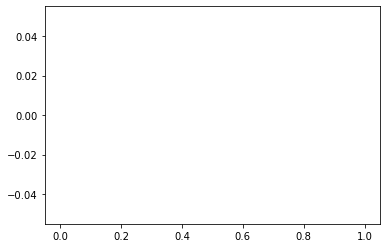

In [19]:
cluster_sizes = []
for cluster in clusters:
    if cluster == -1: #non-clustered
        continue
    
plt.hist(cluster_sizes, 5, facecolor='blue', alpha=0.5)
plt.show()

(1955,)
(1955, 400)
Number of clustered points =  (702,)
Num clusters = 9
[-1  7 -1 ...  1  1  1]
Total # of trojan_nets:  14.0
[-0.43658552 -0.5730801 ]
cluster size = 55
trojan_nets in this cluster:  0.0
[-0.04795974  0.11233655]
cluster size = 85
trojan_nets in this cluster:  13.0
[-0.29409018  0.5859579 ]
cluster size = 59
trojan_nets in this cluster:  0.0
[-0.043485    0.97972095]
cluster size = 117
trojan_nets in this cluster:  0.0
[0.34058928 0.74412125]
cluster size = 42
trojan_nets in this cluster:  0.0
[ 1.0969597  -0.10767345]
cluster size = 198
trojan_nets in this cluster:  0.0
[ 0.21205373 -0.87576413]
cluster size = 84
trojan_nets in this cluster:  0.0
[0.9497499  0.96664405]
cluster size = 62
trojan_nets in this cluster:  0.0


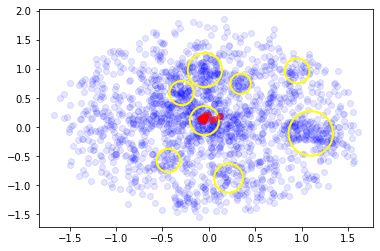

In [24]:
true_labels = np.concatenate((np.zeros(np_embeddings_high_dim.shape[0]), np.ones(np_trojan_embeddings_high_dim.shape[0])))
print(true_labels.shape)
embeddings_low = lowdim
print(embeddings.shape)

from sklearn.cluster import OPTICS, cluster_optics_dbscan

epsilon = 10.0
min_samples = 40
xi = 0.005
cluster_method = 'xi'
metric = 'minkowski'

clust = OPTICS(max_eps=epsilon, min_samples=min_samples, cluster_method=cluster_method, metric=metric, xi = xi)
clust.fit(embeddings_low)

num_clustered_points = clust.labels_[clust.labels_ != -1].shape
print('Number of clustered points = ', num_clustered_points)

clusters = set(clust.labels_)
num_clusters = len(clusters)
print('Num clusters =', num_clusters)
print(clust.labels_)

cluster_centroids = []
cluster_sizes = []
#nums_of_trojan_nets = []
print('Total # of trojan_nets: ', np.sum(true_labels))
for cluster in clusters:
    if cluster == -1: #non-clustered
        continue
    class_member_mask = clust.labels_ == cluster
    xy = embeddings_low[class_member_mask]

    centroid = np.mean(xy, axis=0)
    cluster_size = np.sum(class_member_mask)
    print(centroid)
    print('cluster size =', cluster_size)
    cluster_centroids.append(centroid)
    cluster_sizes.append(cluster_size)
    
    num_of_trojan_nets = np.sum(true_labels[class_member_mask])
    print('trojan_nets in this cluster: ', num_of_trojan_nets)

cluster_centroids = np.array(cluster_centroids)
cluster_sizes = np.array(cluster_sizes)

plt.scatter(embeddings_low.transpose()[0], embeddings_low.transpose()[1], alpha = 0.1, c ="blue")
plt.scatter(cluster_centroids.transpose()[0], cluster_centroids.transpose()[1], s = cluster_sizes * 10, facecolors = 'none', linewidth=2, edgecolors = "yellow")
plt.scatter(lowdim.transpose()[0, np_embeddings_high_dim.shape[0]:], lowdim.transpose()[1, np_embeddings_high_dim.shape[0]:], alpha = 0.5, c ="red")

plt.show()